In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

sns.set_theme()
pd.options.display.max_rows = 500

In [2]:
fields = ['field_overview',
          'field_status',
          'field_operators',
          'field_owners',
          'field_licensees',
          'field_reserves',
          'field_inplaceVol',
          'field_description',
         ]

In [3]:
from load import load

# Overview

In [4]:
overview = load(fields[0])

<AxesSubplot:xlabel='fldCurrentActivitySatus'>

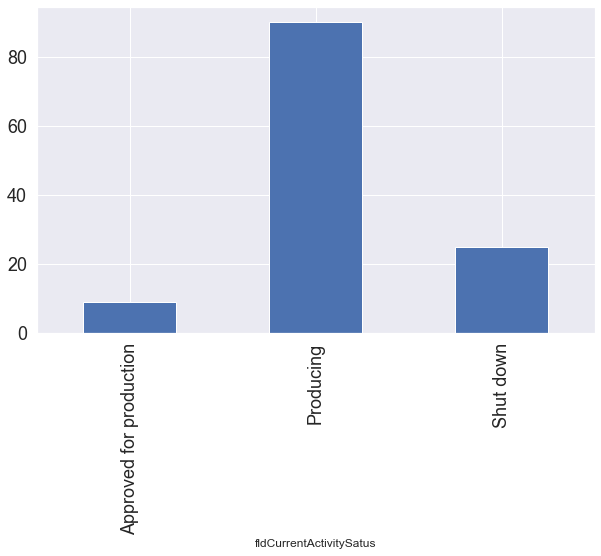

In [5]:
overview.groupby('fldCurrentActivitySatus').size().plot(kind='bar', figsize=(10,6), fontsize=18)

In [6]:
producing_fields = overview[overview['fldCurrentActivitySatus']=='Producing']['cmpLongName'].value_counts()
producing_approved_fields = overview[overview['fldCurrentActivitySatus'].isin(['Approved for production'])]['cmpLongName'].value_counts()
shutdown_fields = overview[overview['fldCurrentActivitySatus']=="Shut down"]['cmpLongName'].value_counts()

print(f"Number of fields: {overview.shape[0]}")
print(f"Number of producing fields: {producing_fields.sum()}")
print(f"Number of producing and approved fields: {producing_approved_fields.sum()}")
print(f"Number of shut down fields: {shutdown_fields.sum()}") # doesn't include 3 NaN entries

Number of fields: 124
Number of producing fields: 90
Number of producing and approved fields: 9
Number of shut down fields: 22


## Status of Fields by Area

fldCurrentActivitySatus  Approved for production  Producing  Shut down
fldMainArea                                                           
Barents Sea                                  1.0        2.0        NaN
North Sea                                    6.0       67.0       24.0
Norwegian Sea                                2.0       21.0        1.0
Column Total                                 9.0       90.0       25.0


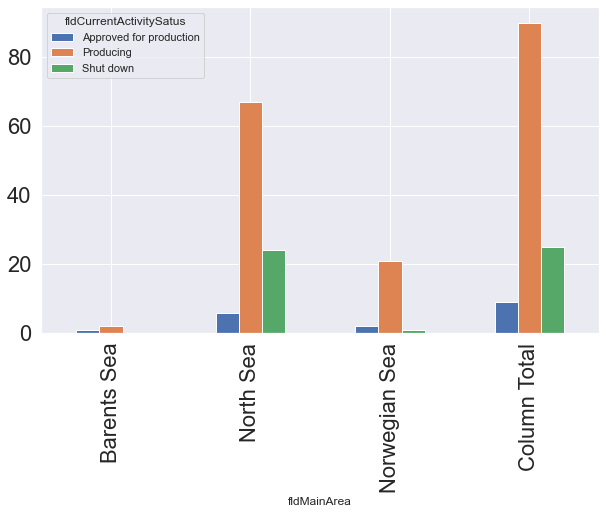

In [7]:
data = overview.groupby(['fldMainArea', 'fldCurrentActivitySatus']).size().unstack()
data.loc['Column Total'] = data.sum(numeric_only=True, axis=0)
print(data)
data.plot(kind='bar', figsize=(10,6), fontsize=22)
plt.show()

# Operators

In [8]:
operators = load(fields[2])

In [9]:
print(f" Number of Operators: {operators['cmpLongName'].nunique()}")
print(f" Number of Fields: {operators['fldName'].nunique()}")

 Number of Operators: 78
 Number of Fields: 124


In [10]:
# Current Operators don't have a date in the 'fldOperatorTo' field
operators[operators['fldOperatorTo'].isnull()]['cmpLongName'].value_counts() # 121 - doesn't include NaN

Equinor Energy AS                   59
Aker BP ASA                         19
ConocoPhillips Skandinavia AS        9
Vår Energi AS                        5
Wintershall Dea Norge AS             5
Repsol Norge AS                      4
A/S Norske Shell                     3
Neptune Energy Norge AS              3
Lundin Energy Norway AS              3
DNO Norge AS                         2
Total E&P Norge AS                   2
Spirit Energy Norway AS              2
Chrysaor Norge AS                    1
OKEA ASA                             1
Total E&P UK Ltd                     1
Petrogas NEO UK Ltd                  1
Repsol Sinopec North Sea Limited     1
Name: cmpLongName, dtype: int64

# Licensees

In [11]:
licensees = load(fields[4])

In [12]:
# Current licences don't have a date in 'fldLicenseeTo' field.
curr_lic = licensees[licensees.fldLicenseeTo.isnull()]

## Current Licensee Companies

In [13]:
licence_companies = list(enumerate(curr_lic.cmpLongName.unique(), start=1))
licence_companies[10-1][1]

'LOTOS Exploration and Production Norge AS'

In [14]:
data = curr_lic.cmpLongName.value_counts()

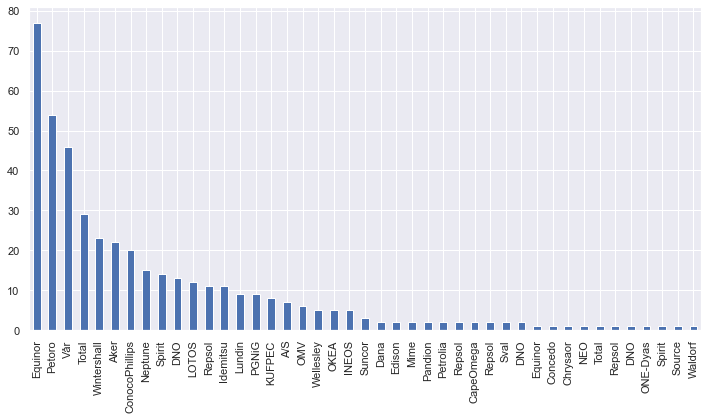

In [15]:
fig, ax = plt.subplots(figsize=(10, 6), tight_layout=True)
data.plot(kind='bar')

labels = data.index
labella = [f'{label.split()[0]}' for label in labels]
ax.xaxis.set_ticklabels(labella)
plt.xticks(rotation=90)
plt.show()

## Number of Licensees per Field

In [16]:
print(f"Number of Licensees: {licensees['cmpLongName'].nunique()}")
print(f"Number of Fields: {licensees['fldName'].nunique()}")

Number of Licensees: 232
Number of Fields: 124


## Field Licences by Company

In [17]:
company = licence_companies[10-1][1]

In [18]:
lotus = licensees[licensees['cmpLongName']==company]

lotus = lotus.loc[lotus.groupby('fldName').fldLicenseeFrom.idxmax(),:]

In [19]:
print(f"Number of licences: {len(lotus)}")

Number of licences: 12


In [20]:
lotus.head()

,fldName,fldOwnerName,fldOwnerKind,fldOwnerFrom,fldOwnerTo,fldLicenseeFrom,fldLicenseeTo,cmpLongName,fldCompanyShare,fldSdfiShare,fldNpdidField,cmpNpdidCompany,fldLicenseeDateUpdated
218,ATLA,102 C,PRODUCTION LICENSE,2011-11-04,NaN,2016-09-30,NaN,LOTOS Exploration and Production Norge AS,20.00,NaN,21106284,5064434,2019-10-03
2223,FRØY,364,PRODUCTION LICENSE,2006-01-06,NaN,2017-07-12,NaN,LOTOS Exploration and Production Norge AS,9.74,NaN,43597,5064434,2019-10-03
2629,GUNGNE,046,PRODUCTION LICENSE,1995-08-29,NaN,2019-12-10,NaN,LOTOS Exploration and Production Norge AS,15.00,NaN,43464,5064434,2019-12-12
2877,HEIMDAL,036 BS,PRODUCTION LICENSE,2003-10-13,NaN,2018-12-04,NaN,LOTOS Exploration and Production Norge AS,5.00,NaN,43590,5064434,2019-10-03
3660,LILLE-FRIGG,873,PRODUCTION LICENSE,2017-02-10,NaN,2018-05-16,NaN,LOTOS Exploration and Production Norge AS,20.00,NaN,43583,5064434,2019-10-03


In [21]:
lotus_fields = lotus['fldName']
lotus_fields

218              ATLA
2223             FRØY
2629           GUNGNE
2877          HEIMDAL
3660      LILLE-FRIGG
5035           SKIRNE
5076    SLEIPNER VEST
5146     SLEIPNER ØST
7323           UTGARD
7330             VALE
8208              YME
8335        ØST FRIGG
Name: fldName, dtype: object

# Status

In [22]:
status = load(fields[1])

In [23]:
# status.head()

In [24]:
status.dropna(inplace=True)

status = status.loc[status.groupby('fldName').fldStatusToDate.idxmax(),:]

In [25]:
status['fldStatus'].value_counts()
#  the headings and values look transposed

Approved for production    91
Producing                  24
Shut down                   1
Name: fldStatus, dtype: int64

In [26]:
status['fldName'].nunique()

116

# In place volumes

In [27]:
inplacevols = load(fields[6])

## In place volumes for specified Company

In [28]:
ipvols_lotus = pd.DataFrame()
# type to list for iterable
for field in list(lotus_fields):
    if field in list(inplacevols['fldName']):
        ipvols_lotus = ipvols_lotus.append(inplacevols[inplacevols['fldName']==field])

ipvols_lotus.loc['Column_Total'] = ipvols_lotus.sum(numeric_only=True, axis=0)

In [29]:
ipvols_lotus

,fldName,fldInplaceOil,fldInplaceAssLiquid,fldInplaceAssGas,fldInplaceFreeGas,fldDateOffResEstDisplay,fldNpdidField
3,ATLA,0.0,0.0,0.0,1.88,2019-12-31,21106284.0
26,FRØY,27.0,0.0,6.0,0.00,2019-12-31,43597.0
37,GUNGNE,0.0,15.0,0.0,19.62,2019-12-31,43464.0
41,HEIMDAL,11.0,0.0,0.0,61.40,2019-12-31,43590.0
54,LILLE-FRIGG,4.0,0.0,7.0,0.00,2019-12-31,43583.0
78,SKIRNE,5.0,0.0,0.0,14.72,2019-12-31,2138816.0
81,SLEIPNER VEST,0.0,79.0,0.0,185.11,2019-12-31,43457.0
82,SLEIPNER ØST,0.0,77.0,0.0,90.70,2019-12-31,43478.0
103,UTGARD,0.0,6.0,0.0,4.97,2019-12-31,28975098.0
104,VALE,0.0,10.0,0.0,8.30,2019-12-31,1578893.0


# Reserves

In [30]:
reserves = load(fields[5])

## Reserves for specified Company

In [31]:
reserves_lotus = pd.DataFrame()
# type to list for iterable
for field in list(lotus_fields):
    if field in list(reserves['fldName']):
        reserves_lotus = reserves_lotus.append(inplacevols[inplacevols['fldName']==field])

# reserves_lotus.loc[:,'Row_Total'] = reserves_lotus.sum(numeric_only=True, axis=1)
reserves_lotus.loc['Column_Total'] = reserves_lotus.sum(numeric_only=True, axis=0)

In [32]:
reserves_lotus

,fldName,fldInplaceOil,fldInplaceAssLiquid,fldInplaceAssGas,fldInplaceFreeGas,fldDateOffResEstDisplay,fldNpdidField
3,ATLA,0.0,0.0,0.0,1.88,2019-12-31,21106284.0
26,FRØY,27.0,0.0,6.0,0.00,2019-12-31,43597.0
37,GUNGNE,0.0,15.0,0.0,19.62,2019-12-31,43464.0
41,HEIMDAL,11.0,0.0,0.0,61.40,2019-12-31,43590.0
54,LILLE-FRIGG,4.0,0.0,7.0,0.00,2019-12-31,43583.0
78,SKIRNE,5.0,0.0,0.0,14.72,2019-12-31,2138816.0
81,SLEIPNER VEST,0.0,79.0,0.0,185.11,2019-12-31,43457.0
82,SLEIPNER ØST,0.0,77.0,0.0,90.70,2019-12-31,43478.0
103,UTGARD,0.0,6.0,0.0,4.97,2019-12-31,28975098.0
104,VALE,0.0,10.0,0.0,8.30,2019-12-31,1578893.0


# Description

In [33]:
description = load(fields[7])

In [34]:
description.head()

,fldName,fldDescriptionHeading,fldDescriptionText,fldNpdidField,fldDescriptionDateUpdated
0,ALBUSKJELL,Development,Albuskjell is a field in the southern part of ...,43437,2020-02-08
1,ALBUSKJELL,Reservoir,Albuskjell produced gas and condensate from Ma...,43437,2018-03-16
2,ALBUSKJELL,Recovery,The field was produced by pressure depletion.,43437,2017-04-11
3,ALBUSKJELL,Transport,The well stream was transported via pipeline t...,43437,2018-03-16
4,ALBUSKJELL,Status,The field was shut down in 1998 and the platfo...,43437,2020-02-08
